# FloPy
### UZF example
Demonstrates functionality of the flopy UZF module using the example from [Niswonger and others (2006)](http://pubs.usgs.gov/tm/2006/tm6a19/). This is the same as the SFR example problem from Prudic and others (2004;
p. 13–19), except the UZF package replaces the ET and RCH packages.

#### Problem description:

* Grid dimensions: 1 Layer, 15 Rows, 10 Columns  
* Stress periods: 12  
* Units are in seconds and days
* Flow package: LPF  
* Stress packages: SFR, GHB, UZF 
* Solver: SIP  

<img src="./img/Niswonger2006_fig13.png" width="400" height="500"/>

In [1]:
import os
import sys
import glob
import platform
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("pandas version: {}".format(pd.__version__))
print("flopy version: {}".format(flopy.__version__))

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy version: 1.21.2
matplotlib version: 3.5.1
pandas version: 1.4.0
flopy version: 3.3.5


In [2]:
# Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = "mf2005"
if platform.system() == "Windows":
    exe_name += ".exe"

In [3]:
path = "temp"
if not os.path.isdir(path):
    os.makedirs(path, exist_ok=True)
gpth = os.path.join("..", "data", "mf2005_test", "UZFtest2.*")
for f in glob.glob(gpth):
    shutil.copy(f, path)

### Load example dataset, skipping the UZF package

In [4]:
m = flopy.modflow.Modflow.load(
    "UZFtest2.nam",
    version="mf2005",
    exe_name=exe_name,
    model_ws=path,
    load_only=["ghb", "dis", "bas6", "oc", "sip", "lpf", "sfr"],
)

### remove previous uzf external file references 
(so they don't conflict with the ones made by flopy)

In [5]:
m.external_fnames

['temp/UZFtest2.uzfot',
 'temp/UZFtest2.uzf1',
 'temp/UZFtest2.uzf2',
 'temp/UZFtest2.uzf3',
 'temp/UZFtest2.uzf4',
 'temp/UZFtest2.sg1',
 'temp/UZFtest2.sg2',
 'temp/UZFtest2.sg3',
 'temp/UZFtest2.sg4',
 'temp/UZFtest2.sg5',
 'temp/UZFtest2.sg6',
 'temp/UZFtest2.sg7',
 'temp/UZFtest2.sg8',
 'temp/UZFtest2dv.sg9']

In [6]:
rm = [True if ".uz" in f else False for f in m.external_fnames]

In [7]:
m.external_fnames = [f for i, f in enumerate(m.external_fnames) if not rm[i]]
m.external_fnames

['temp/UZFtest2.sg1',
 'temp/UZFtest2.sg2',
 'temp/UZFtest2.sg3',
 'temp/UZFtest2.sg4',
 'temp/UZFtest2.sg5',
 'temp/UZFtest2.sg6',
 'temp/UZFtest2.sg7',
 'temp/UZFtest2.sg8',
 'temp/UZFtest2dv.sg9']

In [8]:
m.external_binflag = [f for i, f in enumerate(m.external_binflag) if not rm[i]]
m.external_output = [f for i, f in enumerate(m.external_output) if not rm[i]]
m.external_units = [f for i, f in enumerate(m.external_output) if not rm[i]]

### `izufbnd` array  
* in the example, the UZF package **izufbnd** array is the same as the ibound

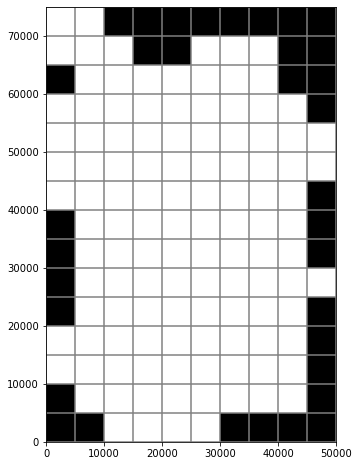

In [9]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=m)
quadmesh = mapview.plot_ibound()
linecollection = mapview.plot_grid()

### Set up the ```irunbnd``` array  
* read this in from an external file

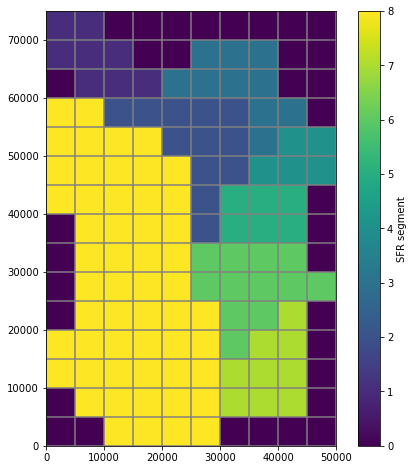

In [10]:
irnbndpth = os.path.join("..", "data", "uzf_examples", "irunbnd.dat")
irunbnd = np.loadtxt(irnbndpth)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=m)
irunbndplt = mapview.plot_array(irunbnd)
plt.colorbar(irunbndplt, ax=ax, label="SFR segment")
linecollection = mapview.plot_grid()

### ``vks`` (unsaturated zone vertical hydraulic conductivity) array

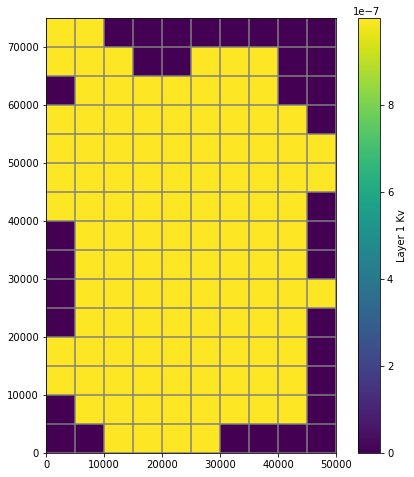

In [11]:
vksbndpth = os.path.join("..", "data", "uzf_examples", "vks.dat")
vks = np.loadtxt(vksbndpth)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=m)
vksplt = mapview.plot_array(vks)
plt.colorbar(vksplt, ax=ax, label="Layer 1 Kv")
linecollection = mapview.plot_grid()

### `finf` array  
* load infiltration rates from a file into a 3D array
* `finf` can be submitted to FloPy as a 3D array, list of 2D arrays, list of numeric values, or single numeric value

In [12]:
m.nrow_ncol_nlay_nper

(15, 10, 1, 12)

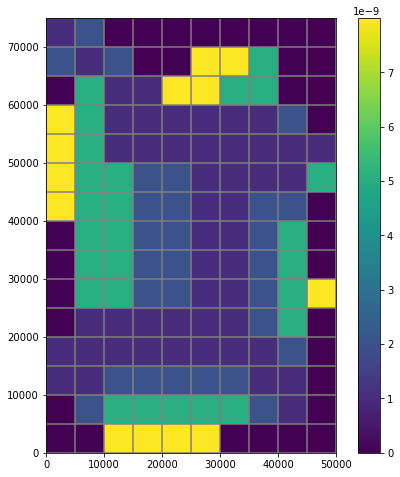

In [13]:
finf = np.loadtxt(os.path.join("..", "data", "uzf_examples", "finf.dat"))
finf = np.reshape(finf, (m.nper, m.nrow, m.ncol))
finf = {i: finf[i] for i in range(finf.shape[0])}

# plot using PlotMapView
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=m)
quadmesh = mapview.plot_array(finf[0])
plt.colorbar(quadmesh)
linecollection = mapview.plot_grid()

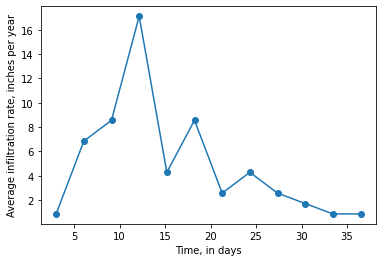

In [14]:
plt.plot(
    m.dis.perlen.array.cumsum() / 864600,
    [a.mean() * 86400 * 365 * 12 for a in finf.values()],
    marker="o",
)
plt.xlabel("Time, in days")
plt.ylabel("Average infiltration rate, inches per year");

### `extwc` (extinction water content) array

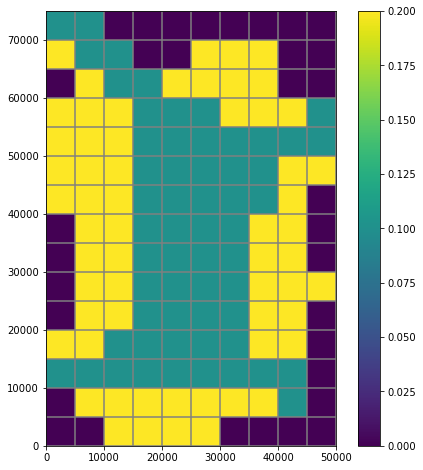

In [15]:
extwc = np.loadtxt(os.path.join("..", "data", "uzf_examples", "extwc.dat"))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mapview = flopy.plot.PlotMapView(model=m)
quadmesh = mapview.plot_array(extwc)
plt.colorbar(quadmesh)
linecollection = mapview.plot_grid()

### Set up the gages (observation points)
* supplied as a dictionary keyed by `IFTUNIT`
* A positive value [of `IFTUNIT`] is for output of individual cells whereas a negative value is for output that is summed over all model cells. 
* values are a list of `[IUZROW, IUZCOL, IFTUNIT, IUZOPT]`
* `IUZROW` and `IUZCOL` are zero based

In [16]:
uzgag = {
    -68: [-68],
    65: [
        2,
        5,
        65,
        1,
    ],  # Print time, head, uz thickness and cum. vols of infiltration, recharge, storage, change in storage and ground-water discharge to land surface.
    66: [
        5,
        2,
        66,
        2,
    ],  # Same as option 1 except rates of infiltration, recharge, change in storage, and ground-water discharge also are printed.
    67: [9, 4, 67, 3],
}  # Prints time, ground-water head, thickness of unsaturated zone, followed by a series of depths and water contents in the unsaturated zone.

### Make the UZF package

In [17]:
uzf = flopy.modflow.ModflowUzf1(
    m,
    nuztop=1,
    iuzfopt=1,
    irunflg=1,
    ietflg=1,
    ipakcb=0,
    iuzfcb2=61,  # binary output of recharge and groundwater discharge
    ntrail2=25,
    nsets=20,
    surfdep=1.0,
    uzgag=uzgag,
    iuzfbnd=m.bas6.ibound.array,
    irunbnd=irunbnd,
    vks=vks,  # saturated vertical hydraulic conductivity of the uz
    finf=finf,  # infiltration rates
    eps=3.5,  # Brooks-Corey relation of water content to hydraulic conductivity (epsilon)
    thts=0.35,  # saturated water content of the uz in units of volume of water to total volume
    pet=5.000000e-08,  # potential ET
    extdp=15.0,  # ET extinction depth(s)
    extwc=extwc,  # extinction water content below which ET cannot be removed from the unsaturated zone
    unitnumber=19,
)

In [18]:
m.write_input()

### run the model

In [19]:
success, buff = m.run_model()
if not success:
    print('"{}...did not run"'.format(m.name))

FloPy is using the following executable to run the model: /Users/jdhughes/.local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: UZFtest2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/03/07 14:22:47



 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Wa

 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Wa

 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Wa

 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     7    Ground-Wa

 Solving:  Stress period:     6    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     5    Ground-Water Flow Eqn.


 Solving:  Stress period:     7    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    12    Ground-Water Flow Eqn.


 Solving:  Stress period:     7    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     9    Ground-Water Flow Eqn.


 Solving:  Stress period:     8    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     2    Ground-Water Flow Eqn.


 Solving:  Stress period:     9    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    12    Ground-Water Flow Eqn.


 Solving:  Stress period:     9    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     6    Ground-Water Flow Eqn.


 Solving:  Stress period:    10    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    14    Ground-Water Flow Eqn.


 Solving:  Stress period:    10    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     9    Ground-Water Flow Eqn.


 Solving:  Stress period:    11    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    15    Ground-Water Flow Eqn.


 Solving:  Stress period:    12    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    11    Ground-Water Flow Eqn.


 Solving:  Stress period:    12    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    15    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/03/07 14:22:51
 Elapsed run time:  3.580 Seconds

  Normal termination of simulation


## Results

### Look at the budget output

In [20]:
fpth = os.path.join(path, "UZFtest2.uzfcb2.bin")
avail = os.path.isfile(fpth)
if avail:
    uzfbdobjct = flopy.utils.CellBudgetFile(fpth)
    uzfbdobjct.list_records()
else:
    print('"{}" is not available'.format(fpth))

(1, 1, b'           GW ET', 10, 15, -1, 4, 2628000., 2628000., 2628000., b'', b'', b'', b'')
(1, 1, b'    UZF RECHARGE', 10, 15, -1, 4, 2628000., 2628000., 2628000., b'', b'', b'', b'')
(1, 1, b' SURFACE LEAKAGE', 10, 15, -1, 4, 2628000., 2628000., 2628000., b'', b'', b'', b'')
(1, 1, b'       HORT+DUNN', 10, 15, -1, 4, 2628000., 2628000., 2628000., b'', b'', b'', b'')
(1, 1, b'  STORAGE CHANGE', 10, 15, -1, 4, 2628000., 2628000., 2628000., b'', b'', b'', b'')
(1, 2, b'           GW ET', 10, 15, -1, 4, 82713.07, 82713.07, 2710713., b'', b'', b'', b'')
(1, 2, b'    UZF RECHARGE', 10, 15, -1, 4, 82713.07, 82713.07, 2710713., b'', b'', b'', b'')
(1, 2, b' SURFACE LEAKAGE', 10, 15, -1, 4, 82713.07, 82713.07, 2710713., b'', b'', b'', b'')
(1, 2, b'       HORT+DUNN', 10, 15, -1, 4, 82713.07, 82713.07, 2710713., b'', b'', b'', b'')
(1, 2, b'  STORAGE CHANGE', 10, 15, -1, 4, 82713.07, 82713.07, 2710713., b'', b'', b'', b'')
(5, 2, b'           GW ET', 10, 15, -1, 4, 121100.21, 504971.6, 313297

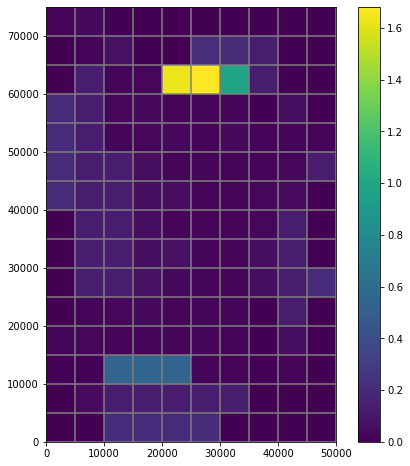

In [21]:
if success and avail:
    r = uzfbdobjct.get_data(text="UZF RECHARGE")
    et = uzfbdobjct.get_data(text="GW ET")

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1, aspect="equal")
    mapview = flopy.plot.PlotMapView(model=m)
    quadmesh = mapview.plot_array(r[6])
    plt.colorbar(quadmesh)
    linecollection = mapview.plot_grid()

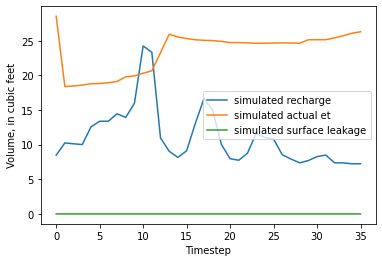

In [22]:
if avail:
    rtot = [rp.sum() for rp in r]
    ettot = [etp.sum() for etp in et]
    sltot = [sl.sum() for sl in uzfbdobjct.get_data(text="SURFACE LEAKAGE")]

    plt.plot(rtot, label="simulated recharge")
    plt.plot(np.abs(ettot), label="simulated actual et")
    plt.plot(np.abs(sltot), label="simulated surface leakage")
    plt.xlabel("Timestep")
    plt.ylabel("Volume, in cubic feet")
    plt.legend()

### Look at the gages

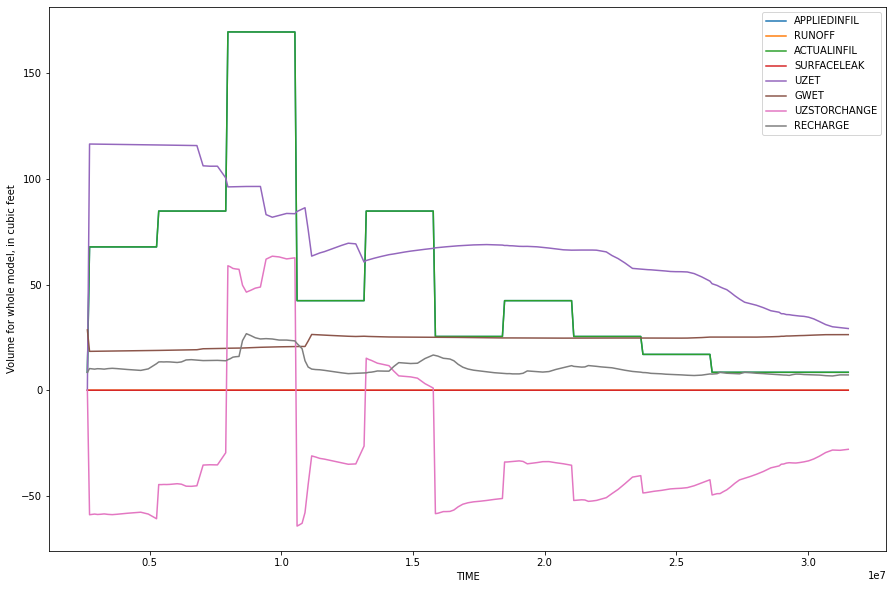

In [23]:
fpth = os.path.join(path, "UZFtest2.uzf68.out")
avail = os.path.isfile(fpth)
if avail:
    dtype = [
        ("TIME", float),
        ("APPLIED-INFIL", float),
        ("RUNOFF", float),
        ("ACTUAL-INFIL", float),
        ("SURFACE-LEAK", float),
        ("UZ-ET", float),
        ("GW-ET", float),
        ("UZSTOR-CHANGE", float),
        ("RECHARGE", float),
    ]
    # read data from file
    df = np.genfromtxt(fpth, skip_header=3, dtype=dtype)
    # convert numpy recarray to pandas dataframe
    df = pd.DataFrame(data=df)
    # set index to the time column
    df.set_index(["TIME"], inplace=True)
    # plot the data
    ax = df.plot(legend=False, figsize=(15, 10))
    patches, labels = ax.get_legend_handles_labels()
    ax.legend(patches, labels, loc=1)
    ax.set_ylabel("Volume for whole model, in cubic feet")

### Plot water content profile through time at row 10, column 5

In [24]:
fpth = os.path.join(path, "UZFtest2.uzf67.out")
avail = os.path.isfile(fpth)
if avail:
    data = []
    with open(fpth) as input:
        for i in range(3):
            next(input)
        for line in input:
            line = line.strip().split()
            if len(line) == 6:
                layer = int(line.pop(0))
                time = float(line.pop(0))
                head = float(line.pop(0))
                uzthick = float(line.pop(0))
            depth = float(line.pop(0))
            watercontent = float(line.pop(0))
            data.append([layer, time, head, uzthick, depth, watercontent])

In [25]:
if avail:
    df3 = pd.DataFrame(
        data,
        columns=["layer", "time", "head", "uzthick", "depth", "watercontent"],
    )
    df3.head(41)

In [26]:
if avail:
    wc = df3.watercontent.values.reshape(len(df3.time.unique()), 40).T
    wc = pd.DataFrame(wc, columns=df3.time.unique(), index=df3.depth[0:40])
    wc.head()

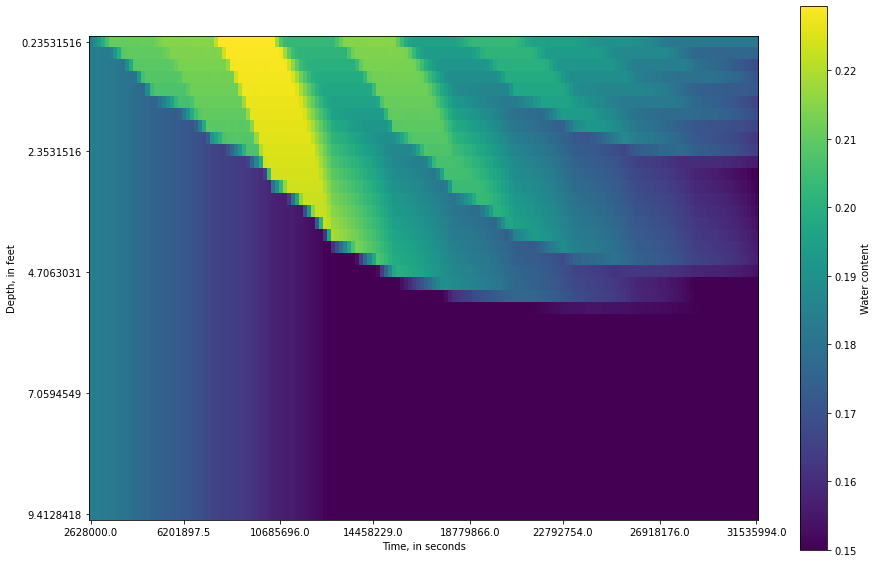

In [27]:
if avail:
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.imshow(wc, interpolation="None")
    ax.set_aspect(3)
    r, c = wc.shape
    xcol_locs = np.linspace(0, c - 1, 8, dtype=int)
    ycol_locs = np.linspace(0, r - 1, 5, dtype=int)
    ax.set_xticks(xcol_locs)

    xlabels = wc.columns
    ax.set_xticklabels(xlabels[xcol_locs])
    ax.set_ylabel("Depth, in feet")
    ax.set_yticks(ycol_locs)
    ax.set_yticklabels(wc.index[ycol_locs])
    ax.set_xlabel("Time, in seconds")
    plt.colorbar(label="Water content")